In [ ]:
# Importing the Basic Libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import plotly.express as px
import sklearn
import tensorflow as tf
print(tf.__version__)
%matplotlib inline
plt.style.use('default')

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

2.12.0
GPU available (YESSSS!!!!!)


* Here we will be using the Yahoo Finance Package `Yfinance` to get the latest Market Data
* We will be using the `1 hr Interval `

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing Data 
import datetime 
import yfinance as yf 
data = yf.download('AMZN' , period = '23mo' , interval = '1h')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-05-03 12:30:00-04:00,169.899750,170.432709,169.205002,169.910278,169.910278,0
2021-05-03 13:30:00-04:00,169.855255,170.457489,169.649994,169.918503,169.918503,462145
2021-05-03 14:30:00-04:00,169.942505,170.092499,169.050003,169.394989,169.394989,488971
2021-05-03 15:30:00-04:00,169.402863,169.412506,168.635056,169.324493,169.324493,657362
2021-05-04 09:30:00-04:00,167.750000,168.398758,165.899994,166.774506,166.774506,1505140
...,...,...,...,...,...,...
2023-03-31 15:30:00-04:00,103.187500,103.419998,102.720001,103.290001,103.290001,8403670
2023-04-03 09:30:00-04:00,102.300003,103.290001,101.699997,102.980003,102.980003,11205337
2023-04-03 10:30:00-04:00,102.985001,103.024002,101.830002,102.150002,102.150002,6041895


In [ ]:
len(data)

3374

In [ ]:
# Creating Another dataframe with only Datetime and Closing Price of the Stock 
stock_prices = pd.DataFrame(data["Close"]).rename(columns = {"Close" : "Price"})
stock_prices.head()

,Price
Datetime,
2021-05-03 12:30:00-04:00,169.910278
2021-05-03 13:30:00-04:00,169.918503
2021-05-03 14:30:00-04:00,169.394989
2021-05-03 15:30:00-04:00,169.324493
2021-05-04 09:30:00-04:00,166.774506


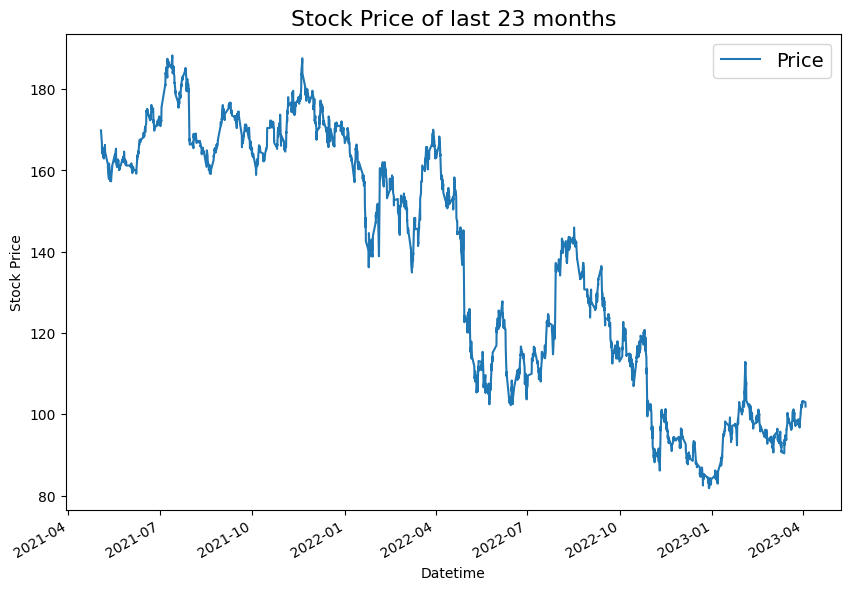

In [ ]:
# Plotting last 23 months price data 
stock_prices.plot(figsize = (10,7))
plt.ylabel("Stock Price")
plt.title("Stock Price of last 23 months" , fontsize = 16)
plt.legend(fontsize = 14);

# Creating Train and Test Sets 

In [ ]:
# Getting the data into numpy array 
timestamps = stock_prices.index.to_numpy()
prices = stock_prices["Price"].to_numpy()
timestamps[10:] , prices[10:]

(array([Timestamp('2021-05-04 15:30:00-0400', tz='America/New_York'),
        Timestamp('2021-05-05 09:30:00-0400', tz='America/New_York'),
        Timestamp('2021-05-05 10:30:00-0400', tz='America/New_York'), ...,
        Timestamp('2023-04-03 10:30:00-0400', tz='America/New_York'),
        Timestamp('2023-04-03 11:30:00-0400', tz='America/New_York'),
        Timestamp('2023-04-03 12:30:00-0400', tz='America/New_York')],
       dtype=object),
 array([165.63249207, 165.58850098, 165.36724854, ..., 102.15000153,
        102.18000031, 101.90499878]))

In [ ]:
# Create train and test splits

split_size = int(0.8 * len(prices))

X_train , y_train = timestamps[:split_size], prices[:split_size]
X_test , y_test = timestamps[split_size:] , prices[split_size:]

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2699, 675, 2699, 675)

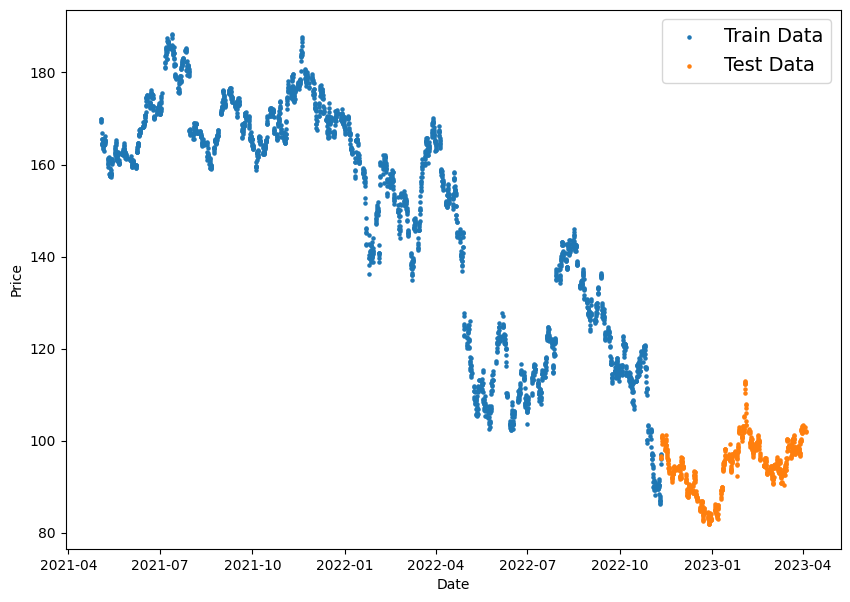

In [ ]:
# Vizualizing the train and test data 
plt.figure(figsize = (10,7))
plt.scatter(X_train , y_train , s = 5 , label = "Train Data")
plt.scatter(X_test , y_test , s = 5 , label = "Test Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize = 14)
plt.show();

In [ ]:
# Creating function for plotting timeseries 
def plot_time_series(timestamps , values , format = "." , start = 0, end = None , label = None):
  plt.plot(timestamps[start:end], values[start:end] , format , label = label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=  14)
  plt.grid(True)

## Evaluating Model

In [ ]:
# Building MASE Function 
def mean_absoulte_scaled_error(y_true , y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [ ]:
def make_preds(model , input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Building function for evaluating
def evaluate_preds(y_true , y_pred):
  y_true =  tf.cast(y_true , dtype = tf.float32)
  y_pred =  tf.cast(y_pred , dtype = tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)
  mase = tf.keras.metrics.mean_absoulte_scaled_error(y_true , y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {
      "mae" : mae.numpy(),
      "mse" : mse.numpy(),
      "rmse" : rmse.numpy(),
      "mape" : mape.numpy(),
      "mase" : mase.numpy(),
  }

# Model Multivariate Time series

Here we will use the `MACD` and the `Signal` of it to predict the model 

In [ ]:
# Define MACD parameters
fast_period = 12
slow_period = 26
signal_period = 9

# Calculate MACD using pandas
ema_fast = pd.Series(data["Close"]).ewm(span=fast_period).mean()
ema_slow = pd.Series(data["Close"]).ewm(span=slow_period).mean()
macd = pd.Series(ema_fast - ema_slow, name="MACD")
signal = pd.Series(macd.ewm(span=signal_period).mean(), name="Signal")

In [ ]:
# Adding the MACD and Signal Column into our stock_price dataset
stock_prices['Macd'] = macd
stock_prices['Signal'] = signal
stock_prices

,Price,Macd,Signal
Datetime,,,
2021-05-03 12:30:00-04:00,169.910278,0.000000,0.000000
2021-05-03 13:30:00-04:00,169.918503,0.000185,0.000103
2021-05-03 14:30:00-04:00,169.394989,-0.015999,-0.006496
2021-05-03 15:30:00-04:00,169.324493,-0.025513,-0.012938
2021-05-04 09:30:00-04:00,166.774506,-0.131615,-0.048242
...,...,...,...
2023-03-31 15:30:00-04:00,103.290001,1.135583,1.057530
2023-04-03 09:30:00-04:00,102.980003,1.094736,1.064971
2023-04-03 10:30:00-04:00,102.150002,0.984046,1.048786


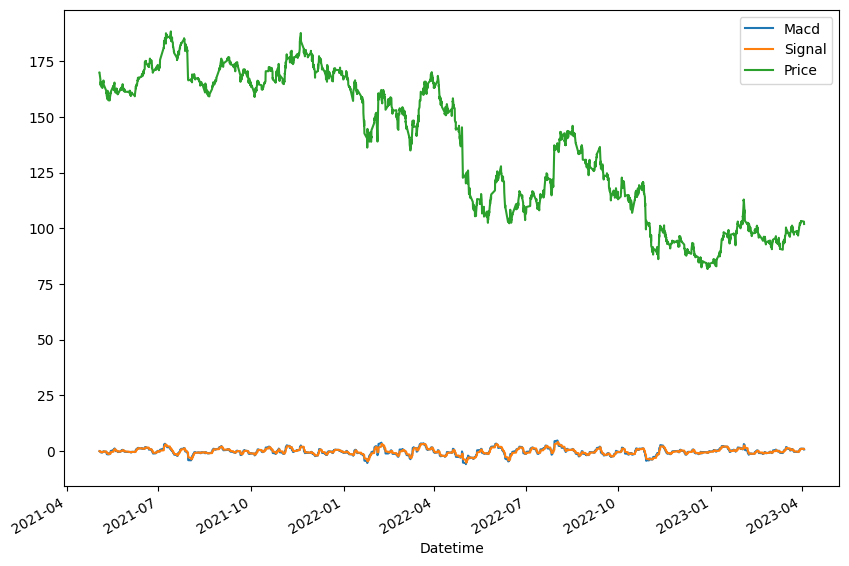

In [ ]:
# Plot the MACD
stock_prices["Macd"].plot(figsize=(10,7))
stock_prices["Signal"].plot(figsize=(10,7))
stock_prices['Price'].plot(figsize=(10,7))
plt.legend()

In [ ]:
HORIZON =  1
WINDOW_SIZE = 7

In [ ]:
# Making copy of our stock_price dataframe
stock_prices_windowed = stock_prices.copy()

# Adding Windows in a Range
for i in range(WINDOW_SIZE):
  stock_prices_windowed[f"Price+{i+1}"] = stock_prices_windowed["Price"].shift(periods = i+1)
stock_prices_windowed.tail(10)

,Price,Macd,Signal,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Datetime,,,,,,,,,,
2023-03-31 10:30:00-04:00,102.910004,1.098868,0.887494,102.489998,102.000000,101.949997,101.654999,101.629997,102.049896,102.315002
2023-03-31 11:30:00-04:00,103.135002,1.143383,0.938672,102.910004,102.489998,102.000000,101.949997,101.654999,101.629997,102.049896
2023-03-31 12:30:00-04:00,102.949997,1.150472,0.981032,103.135002,102.910004,102.489998,102.000000,101.949997,101.654999,101.629997
2023-03-31 13:30:00-04:00,102.900002,1.138927,1.012611,102.949997,103.135002,102.910004,102.489998,102.000000,101.949997,101.654999
2023-03-31 14:30:00-04:00,103.184998,1.139637,1.038016,102.900002,102.949997,103.135002,102.910004,102.489998,102.000000,101.949997
2023-03-31 15:30:00-04:00,103.290001,1.135583,1.057530,103.184998,102.900002,102.949997,103.135002,102.910004,102.489998,102.000000
2023-04-03 09:30:00-04:00,102.980003,1.094736,1.064971,103.290001,103.184998,102.900002,102.949997,103.135002,102.910004,102.489998
2023-04-03 10:30:00-04:00,102.150002,0.984046,1.048786,102.980003,103.290001,103.184998,102.900002,102.949997,103.135002,102.910004
2023-04-03 11:30:00-04:00,102.180000,0.888503,1.016729,102.150002,102.980003,103.290001,103.184998,102.900002,102.949997,103.135002


In [ ]:
# Creating X (Window) and Y (Horizon) features
X = stock_prices_windowed.dropna().drop("Price" , axis = 1).astype(np.float32)
Y = stock_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
# SPlitting the Train and Test using Indexing 
split_size = int(len(X) * 0.8)
X_train , Y_train , = X[:split_size] , Y[:split_size] # Training on past
X_test , Y_test = X[split_size:] , Y[split_size:] # Testing on Present

len(X_train) , len(Y_train) , len(X_test) , len(Y_test)

(2693, 2693, 674, 674)

## Modelling Checkpoint Callback 
this will help us to enable and let us know from which epoch does the loss get more bigger 

In [ ]:
import os 

# Function to implement a modelcheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "/content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose = 1,
                                            save_best_only = True,
                                            )

# Modelling 

## Model 1 

In [ ]:
# Building the model 1 on (Multivariate Time Series)
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(HORIZON)
], name = "model_1_multivariate")

model_1.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae" , "mse"],
)

history_1 = model_1.fit(
    x = X_train,
    y = Y_train,
    epochs = 100,
    batch_size = 128,
    verbose = 1,
    validation_data = (X_test , Y_test),
    callbacks = [create_model_checkpoint(model_name = model_1.name)]
)

Epoch 1/100
16/22 [====================>.........] - ETA: 0s - loss: 150.3926 - mae: 150.3926 - mse: 25117.9512 
Epoch 1: val_loss improved from inf to 9.44209, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 3s 43ms/step - loss: 127.0249 - mae: 127.0249 - mse: 19837.9844 - val_loss: 9.4421 - val_mae: 9.4421 - val_mse: 92.0572
Epoch 2/100
19/22 [========================>.....] - ETA: 0s - loss: 14.6434 - mae: 14.6434 - mse: 289.8290
Epoch 2: val_loss improved from 9.44209 to 5.57762, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 29ms/step - loss: 14.2966 - mae: 14.2966 - mse: 274.4789 - val_loss: 5.5776 - val_mae: 5.5776 - val_mse: 33.7585
Epoch 3/100
19/22 [========================>.....] - ETA: 0s - loss: 4.0196 - mae: 4.0196 - mse: 24.1812
Epoch 3: val_loss improved from 5.57762 to 1.32682, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 30ms/step - loss: 3.8915 - mae: 3.8915 - mse: 22.9396 - val_loss: 1.3268 - val_mae: 1.3268 - val_mse: 3.0809
Epoch 4/100
12/22 [===============>..............] - ETA: 0s - loss: 2.0993 - mae: 2.0993 - mse: 7.5699
Epoch 4: val_loss improved from 1.32682 to 1.09695, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 41ms/step - loss: 1.9073 - mae: 1.9073 - mse: 6.4799 - val_loss: 1.0970 - val_mae: 1.0970 - val_mse: 2.1540
Epoch 5/100
13/22 [================>.............] - ETA: 0s - loss: 1.4460 - mae: 1.4460 - mse: 4.2442
Epoch 5: val_loss improved from 1.09695 to 1.04852, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 39ms/step - loss: 1.4413 - mae: 1.4413 - mse: 4.2401 - val_loss: 1.0485 - val_mae: 1.0485 - val_mse: 1.9322
Epoch 6/100
21/22 [===========================>..] - ETA: 0s - loss: 1.4253 - mae: 1.4253 - mse: 4.0972
Epoch 6: val_loss did not improve from 1.04852
22/22 [==============================] - 0s 8ms/step - loss: 1.4265 - mae: 1.4265 - mse: 4.0998 - val_loss: 1.0805 - val_mae: 1.0805 - val_mse: 2.0215
Epoch 7/100
13/22 [================>.............] - ETA: 0s - loss: 1.4893 - mae: 1.4893 - mse: 4.5856
Epoch 7: val_loss improved from 1.04852 to 1.02859, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 59ms/step - loss: 1.4395 - mae: 1.4395 - mse: 4.1108 - val_loss: 1.0286 - val_mae: 1.0286 - val_mse: 1.8719
Epoch 8/100
20/22 [==========================>...] - ETA: 0s - loss: 1.4295 - mae: 1.4295 - mse: 4.0105
Epoch 8: val_loss did not improve from 1.02859
22/22 [==============================] - 0s 10ms/step - loss: 1.4324 - mae: 1.4324 - mse: 4.1070 - val_loss: 1.1839 - val_mae: 1.1839 - val_mse: 2.3985
Epoch 9/100
13/22 [================>.............] - ETA: 0s - loss: 1.5960 - mae: 1.5960 - mse: 4.6407
Epoch 9: val_loss improved from 1.02859 to 1.02730, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 31ms/step - loss: 1.5826 - mae: 1.5826 - mse: 4.6223 - val_loss: 1.0273 - val_mae: 1.0273 - val_mse: 1.8933
Epoch 10/100
20/22 [==========================>...] - ETA: 0s - loss: 1.4079 - mae: 1.4079 - mse: 3.9684
Epoch 10: val_loss improved from 1.02730 to 0.98511, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 30ms/step - loss: 1.4103 - mae: 1.4103 - mse: 3.9676 - val_loss: 0.9851 - val_mae: 0.9851 - val_mse: 1.7403
Epoch 11/100
18/22 [=======================>......] - ETA: 0s - loss: 1.3386 - mae: 1.3386 - mse: 3.7509
Epoch 11: val_loss did not improve from 0.98511
22/22 [==============================] - 0s 6ms/step - loss: 1.3272 - mae: 1.3272 - mse: 3.6415 - val_loss: 1.0729 - val_mae: 1.0729 - val_mse: 1.9774
Epoch 12/100
15/22 [===================>..........] - ETA: 0s - loss: 1.4328 - mae: 1.4328 - mse: 3.9860
Epoch 12: val_loss did not improve from 0.98511
22/22 [==============================] - 0s 5ms/step - loss: 1.4224 - mae: 1.4224 - mse: 3.9628 - val_loss: 1.0745 - val_mae: 1.0745 - val_mse: 2.0286
Epoch 13/100
19/22 [========================>.....] - ETA: 0s - loss: 1.4786 - mae: 1.4786 - mse: 4.1898
Epoch 13: val_loss improved from 0.98511 to 0.94753, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/m

22/22 [==============================] - 1s 29ms/step - loss: 1.4559 - mae: 1.4559 - mse: 4.0757 - val_loss: 0.9475 - val_mae: 0.9475 - val_mse: 1.6365
Epoch 14/100
19/22 [========================>.....] - ETA: 0s - loss: 1.2994 - mae: 1.2994 - mse: 3.5308
Epoch 14: val_loss did not improve from 0.94753
22/22 [==============================] - 0s 6ms/step - loss: 1.3122 - mae: 1.3122 - mse: 3.5668 - val_loss: 1.2584 - val_mae: 1.2584 - val_mse: 2.5709
Epoch 15/100
17/22 [======================>.......] - ETA: 0s - loss: 1.6500 - mae: 1.6500 - mse: 4.6636
Epoch 15: val_loss did not improve from 0.94753
22/22 [==============================] - 0s 6ms/step - loss: 1.6020 - mae: 1.6020 - mse: 4.5308 - val_loss: 1.1494 - val_mae: 1.1494 - val_mse: 2.1717
Epoch 16/100
15/22 [===================>..........] - ETA: 0s - loss: 1.4200 - mae: 1.4200 - mse: 3.8539
Epoch 16: val_loss did not improve from 0.94753
22/22 [==============================] - 0s 6ms/step - loss: 1.3866 - mae: 1.3866 - mse

22/22 [==============================] - 1s 29ms/step - loss: 1.3704 - mae: 1.3704 - mse: 3.6328 - val_loss: 0.8935 - val_mae: 0.8935 - val_mse: 1.4791
Epoch 19/100
18/22 [=======================>......] - ETA: 0s - loss: 1.2956 - mae: 1.2956 - mse: 3.3303
Epoch 19: val_loss did not improve from 0.89351
22/22 [==============================] - 0s 5ms/step - loss: 1.2929 - mae: 1.2929 - mse: 3.3553 - val_loss: 0.9181 - val_mae: 0.9181 - val_mse: 1.5479
Epoch 20/100
15/22 [===================>..........] - ETA: 0s - loss: 1.2202 - mae: 1.2202 - mse: 3.2558
Epoch 20: val_loss did not improve from 0.89351
22/22 [==============================] - 0s 6ms/step - loss: 1.2308 - mae: 1.2308 - mse: 3.1754 - val_loss: 1.6014 - val_mae: 1.6014 - val_mse: 3.5790
Epoch 21/100
19/22 [========================>.....] - ETA: 0s - loss: 1.5238 - mae: 1.5238 - mse: 4.1540
Epoch 21: val_loss did not improve from 0.89351
22/22 [==============================] - 0s 5ms/step - loss: 1.4933 - mae: 1.4933 - mse

22/22 [==============================] - 1s 28ms/step - loss: 1.1981 - mae: 1.1981 - mse: 3.0617 - val_loss: 0.8624 - val_mae: 0.8624 - val_mse: 1.3894
Epoch 23/100
18/22 [=======================>......] - ETA: 0s - loss: 1.1388 - mae: 1.1388 - mse: 2.7601
Epoch 23: val_loss did not improve from 0.86244
22/22 [==============================] - 0s 5ms/step - loss: 1.1691 - mae: 1.1691 - mse: 2.9092 - val_loss: 0.9641 - val_mae: 0.9641 - val_mse: 1.6168
Epoch 24/100
19/22 [========================>.....] - ETA: 0s - loss: 1.3062 - mae: 1.3062 - mse: 3.3256
Epoch 24: val_loss did not improve from 0.86244
22/22 [==============================] - 0s 5ms/step - loss: 1.3069 - mae: 1.3069 - mse: 3.3169 - val_loss: 0.8897 - val_mae: 0.8897 - val_mse: 1.4380
Epoch 25/100
19/22 [========================>.....] - ETA: 0s - loss: 1.2272 - mae: 1.2272 - mse: 2.9667
Epoch 25: val_loss did not improve from 0.86244
22/22 [==============================] - 0s 6ms/step - loss: 1.2200 - mae: 1.2200 - mse

22/22 [==============================] - 1s 30ms/step - loss: 1.2853 - mae: 1.2853 - mse: 3.2307 - val_loss: 0.8199 - val_mae: 0.8199 - val_mse: 1.2795
Epoch 27/100
19/22 [========================>.....] - ETA: 0s - loss: 1.1156 - mae: 1.1156 - mse: 2.5749
Epoch 27: val_loss improved from 0.81993 to 0.79812, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 28ms/step - loss: 1.1332 - mae: 1.1332 - mse: 2.7368 - val_loss: 0.7981 - val_mae: 0.7981 - val_mse: 1.2322
Epoch 28/100
18/22 [=======================>......] - ETA: 0s - loss: 1.0976 - mae: 1.0976 - mse: 2.7150
Epoch 28: val_loss improved from 0.79812 to 0.78849, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 30ms/step - loss: 1.0922 - mae: 1.0922 - mse: 2.6214 - val_loss: 0.7885 - val_mae: 0.7885 - val_mse: 1.2066
Epoch 29/100
20/22 [==========================>...] - ETA: 0s - loss: 1.0840 - mae: 1.0840 - mse: 2.5917
Epoch 29: val_loss did not improve from 0.78849
22/22 [==============================] - 0s 5ms/step - loss: 1.0875 - mae: 1.0875 - mse: 2.5887 - val_loss: 1.5254 - val_mae: 1.5254 - val_mse: 3.1707
Epoch 30/100
18/22 [=======================>......] - ETA: 0s - loss: 1.5562 - mae: 1.5562 - mse: 4.2046
Epoch 30: val_loss did not improve from 0.78849
22/22 [==============================] - 0s 5ms/step - loss: 1.4986 - mae: 1.4986 - mse: 3.9524 - val_loss: 0.8598 - val_mae: 0.8598 - val_mse: 1.3411
Epoch 31/100
19/22 [========================>.....] - ETA: 0s - loss: 1.1352 - mae: 1.1352 - mse: 2.7395
Epoch 31: val_loss did not improve from 0.78849
22/22 [==============================] - 0s 5ms/step - loss: 1.1296 - mae: 1.1296 - mse

22/22 [==============================] - 1s 28ms/step - loss: 1.2528 - mae: 1.2528 - mse: 3.0302 - val_loss: 0.7573 - val_mae: 0.7573 - val_mse: 1.1310
Epoch 34/100
19/22 [========================>.....] - ETA: 0s - loss: 1.0592 - mae: 1.0592 - mse: 2.4024
Epoch 34: val_loss improved from 0.75728 to 0.75334, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 29ms/step - loss: 1.0672 - mae: 1.0672 - mse: 2.5020 - val_loss: 0.7533 - val_mae: 0.7533 - val_mse: 1.1161
Epoch 35/100
19/22 [========================>.....] - ETA: 0s - loss: 1.0281 - mae: 1.0281 - mse: 2.3945
Epoch 35: val_loss did not improve from 0.75334
22/22 [==============================] - 0s 5ms/step - loss: 1.0316 - mae: 1.0316 - mse: 2.3909 - val_loss: 1.0512 - val_mae: 1.0512 - val_mse: 1.7775
Epoch 36/100
20/22 [==========================>...] - ETA: 0s - loss: 1.1719 - mae: 1.1719 - mse: 2.7902
Epoch 36: val_loss did not improve from 0.75334
22/22 [==============================] - 0s 5ms/step - loss: 1.1690 - mae: 1.1690 - mse: 2.7868 - val_loss: 1.2208 - val_mae: 1.2208 - val_mse: 2.1833
Epoch 37/100
17/22 [======================>.......] - ETA: 0s - loss: 1.4238 - mae: 1.4238 - mse: 3.6317
Epoch 37: val_loss did not improve from 0.75334
22/22 [==============================] - 0s 11ms/step - loss: 1.3873 - mae: 1.3873 - ms

22/22 [==============================] - 2s 111ms/step - loss: 1.1999 - mae: 1.1999 - mse: 2.8568 - val_loss: 0.7206 - val_mae: 0.7206 - val_mse: 1.0379
Epoch 45/100
19/22 [========================>.....] - ETA: 0s - loss: 0.9882 - mae: 0.9882 - mse: 2.2460
Epoch 45: val_loss did not improve from 0.72059
22/22 [==============================] - 0s 14ms/step - loss: 0.9905 - mae: 0.9905 - mse: 2.2055 - val_loss: 0.7743 - val_mae: 0.7743 - val_mse: 1.1286
Epoch 46/100
17/22 [======================>.......] - ETA: 0s - loss: 1.1570 - mae: 1.1570 - mse: 2.7002
Epoch 46: val_loss did not improve from 0.72059
22/22 [==============================] - 0s 18ms/step - loss: 1.1560 - mae: 1.1560 - mse: 2.6040 - val_loss: 0.9180 - val_mae: 0.9180 - val_mse: 1.4213
Epoch 47/100
19/22 [========================>.....] - ETA: 0s - loss: 1.2464 - mae: 1.2464 - mse: 2.8469
Epoch 47: val_loss improved from 0.72059 to 0.71727, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Mode

22/22 [==============================] - 1s 70ms/step - loss: 1.2565 - mae: 1.2565 - mse: 2.8730 - val_loss: 0.7173 - val_mae: 0.7173 - val_mse: 1.0164
Epoch 48/100
18/22 [=======================>......] - ETA: 0s - loss: 1.1450 - mae: 1.1450 - mse: 2.6495
Epoch 48: val_loss did not improve from 0.71727
22/22 [==============================] - 0s 9ms/step - loss: 1.1474 - mae: 1.1474 - mse: 2.5999 - val_loss: 0.9619 - val_mae: 0.9619 - val_mse: 1.5016
Epoch 49/100
19/22 [========================>.....] - ETA: 0s - loss: 1.1153 - mae: 1.1153 - mse: 2.5371
Epoch 49: val_loss improved from 0.71727 to 0.69509, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate


22/22 [==============================] - 1s 56ms/step - loss: 1.1070 - mae: 1.1070 - mse: 2.4877 - val_loss: 0.6951 - val_mae: 0.6951 - val_mse: 0.9790
Epoch 50/100
14/22 [==================>...........] - ETA: 0s - loss: 1.0762 - mae: 1.0762 - mse: 2.4149
Epoch 50: val_loss did not improve from 0.69509
22/22 [==============================] - 0s 9ms/step - loss: 1.0756 - mae: 1.0756 - mse: 2.4063 - val_loss: 0.7383 - val_mae: 0.7383 - val_mse: 1.0525
Epoch 51/100
18/22 [=======================>......] - ETA: 0s - loss: 1.0545 - mae: 1.0545 - mse: 2.2842
Epoch 51: val_loss did not improve from 0.69509
22/22 [==============================] - 0s 9ms/step - loss: 1.0542 - mae: 1.0542 - mse: 2.3323 - val_loss: 0.7061 - val_mae: 0.7061 - val_mse: 0.9930
Epoch 52/100
22/22 [==============================] - ETA: 0s - loss: 0.9625 - mae: 0.9625 - mse: 2.0957
Epoch 52: val_loss improved from 0.69509 to 0.68765, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/m

22/22 [==============================] - 1s 57ms/step - loss: 0.9625 - mae: 0.9625 - mse: 2.0957 - val_loss: 0.6876 - val_mae: 0.6876 - val_mse: 0.9603
Epoch 53/100
17/22 [======================>.......] - ETA: 0s - loss: 0.9816 - mae: 0.9816 - mse: 2.0829
Epoch 53: val_loss did not improve from 0.68765
22/22 [==============================] - 0s 12ms/step - loss: 0.9969 - mae: 0.9969 - mse: 2.1652 - val_loss: 0.9080 - val_mae: 0.9080 - val_mse: 1.3800
Epoch 54/100
16/22 [====================>.........] - ETA: 0s - loss: 1.0669 - mae: 1.0669 - mse: 2.3613
Epoch 54: val_loss did not improve from 0.68765
22/22 [==============================] - 0s 14ms/step - loss: 1.0499 - mae: 1.0499 - mse: 2.3218 - val_loss: 0.8609 - val_mae: 0.8609 - val_mse: 1.2824
Epoch 55/100
17/22 [======================>.......] - ETA: 0s - loss: 1.1171 - mae: 1.1171 - mse: 2.5047
Epoch 55: val_loss improved from 0.68765 to 0.68763, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model

22/22 [==============================] - 1s 56ms/step - loss: 1.1096 - mae: 1.1096 - mse: 2.4301 - val_loss: 0.6876 - val_mae: 0.6876 - val_mse: 0.9551
Epoch 56/100
20/22 [==========================>...] - ETA: 0s - loss: 1.0035 - mae: 1.0035 - mse: 2.1698
Epoch 56: val_loss did not improve from 0.68763
22/22 [==============================] - 0s 9ms/step - loss: 0.9963 - mae: 0.9963 - mse: 2.1328 - val_loss: 0.8755 - val_mae: 0.8755 - val_mse: 1.2991
Epoch 57/100
15/22 [===================>..........] - ETA: 0s - loss: 1.0065 - mae: 1.0065 - mse: 2.1785
Epoch 57: val_loss did not improve from 0.68763
22/22 [==============================] - 0s 11ms/step - loss: 0.9916 - mae: 0.9916 - mse: 2.1375 - val_loss: 0.7196 - val_mae: 0.7196 - val_mse: 1.0084
Epoch 58/100
12/22 [===============>..............] - ETA: 0s - loss: 1.0022 - mae: 1.0022 - mse: 2.0615
Epoch 58: val_loss did not improve from 0.68763
22/22 [==============================] - 0s 8ms/step - loss: 0.9858 - mae: 0.9858 - ms

22/22 [==============================] - 1s 69ms/step - loss: 0.9866 - mae: 0.9866 - mse: 2.1049 - val_loss: 0.6858 - val_mae: 0.6858 - val_mse: 0.9430
Epoch 67/100
22/22 [==============================] - ETA: 0s - loss: 0.9301 - mae: 0.9301 - mse: 1.9684
Epoch 67: val_loss did not improve from 0.68579
22/22 [==============================] - 0s 11ms/step - loss: 0.9301 - mae: 0.9301 - mse: 1.9684 - val_loss: 0.7679 - val_mae: 0.7679 - val_mse: 1.0854
Epoch 68/100
17/22 [======================>.......] - ETA: 0s - loss: 1.0219 - mae: 1.0219 - mse: 2.2626
Epoch 68: val_loss did not improve from 0.68579
22/22 [==============================] - 0s 11ms/step - loss: 0.9938 - mae: 0.9938 - mse: 2.1291 - val_loss: 1.1217 - val_mae: 1.1217 - val_mse: 1.8508
Epoch 69/100
13/22 [================>.............] - ETA: 0s - loss: 1.1652 - mae: 1.1652 - mse: 2.6038
Epoch 69: val_loss improved from 0.68579 to 0.67408, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model

22/22 [==============================] - 3s 143ms/step - loss: 1.0668 - mae: 1.0668 - mse: 2.3375 - val_loss: 0.6741 - val_mae: 0.6741 - val_mse: 0.9179
Epoch 70/100
22/22 [==============================] - ETA: 0s - loss: 1.0748 - mae: 1.0748 - mse: 2.3100
Epoch 70: val_loss did not improve from 0.67408
22/22 [==============================] - 0s 16ms/step - loss: 1.0748 - mae: 1.0748 - mse: 2.3100 - val_loss: 0.6808 - val_mae: 0.6808 - val_mse: 0.9328
Epoch 71/100
18/22 [=======================>......] - ETA: 0s - loss: 0.9499 - mae: 0.9499 - mse: 2.0357
Epoch 71: val_loss did not improve from 0.67408
22/22 [==============================] - 0s 21ms/step - loss: 0.9581 - mae: 0.9581 - mse: 2.0294 - val_loss: 0.6752 - val_mae: 0.6752 - val_mse: 0.9187
Epoch 72/100
15/22 [===================>..........] - ETA: 0s - loss: 0.9154 - mae: 0.9154 - mse: 1.9053
Epoch 72: val_loss improved from 0.67408 to 0.67004, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Mode

22/22 [==============================] - 1s 59ms/step - loss: 0.9215 - mae: 0.9215 - mse: 1.9399 - val_loss: 0.6700 - val_mae: 0.6700 - val_mse: 0.9098
Epoch 73/100
22/22 [==============================] - ETA: 0s - loss: 0.9473 - mae: 0.9473 - mse: 1.9973
Epoch 73: val_loss did not improve from 0.67004
22/22 [==============================] - 0s 11ms/step - loss: 0.9473 - mae: 0.9473 - mse: 1.9973 - val_loss: 0.7802 - val_mae: 0.7802 - val_mse: 1.0979
Epoch 74/100
21/22 [===========================>..] - ETA: 0s - loss: 0.9707 - mae: 0.9707 - mse: 2.0662
Epoch 74: val_loss did not improve from 0.67004
22/22 [==============================] - 0s 9ms/step - loss: 0.9715 - mae: 0.9715 - mse: 2.0678 - val_loss: 0.6807 - val_mae: 0.6807 - val_mse: 0.9235
Epoch 75/100
21/22 [===========================>..] - ETA: 0s - loss: 0.9409 - mae: 0.9409 - mse: 1.9847
Epoch 75: val_loss did not improve from 0.67004
22/22 [==============================] - 0s 10ms/step - loss: 0.9404 - mae: 0.9404 - m

22/22 [==============================] - 1s 46ms/step - loss: 0.9209 - mae: 0.9209 - mse: 1.9415 - val_loss: 0.6648 - val_mae: 0.6648 - val_mse: 0.8934
Epoch 83/100
20/22 [==========================>...] - ETA: 0s - loss: 1.0523 - mae: 1.0523 - mse: 2.2385
Epoch 83: val_loss did not improve from 0.66480
22/22 [==============================] - 0s 10ms/step - loss: 1.0561 - mae: 1.0561 - mse: 2.2437 - val_loss: 1.0543 - val_mae: 1.0543 - val_mse: 1.6669
Epoch 84/100
12/22 [===============>..............] - ETA: 0s - loss: 1.2068 - mae: 1.2068 - mse: 2.8392
Epoch 84: val_loss did not improve from 0.66480
22/22 [==============================] - 0s 9ms/step - loss: 1.0734 - mae: 1.0734 - mse: 2.3162 - val_loss: 0.9725 - val_mae: 0.9725 - val_mse: 1.4960
Epoch 85/100
12/22 [===============>..............] - ETA: 0s - loss: 1.1751 - mae: 1.1751 - mse: 2.5354
Epoch 85: val_loss did not improve from 0.66480
22/22 [==============================] - 0s 8ms/step - loss: 1.1215 - mae: 1.1215 - ms

22/22 [==============================] - 1s 30ms/step - loss: 0.9661 - mae: 0.9661 - mse: 2.0129 - val_loss: 0.6563 - val_mae: 0.6563 - val_mse: 0.8779
Epoch 100/100
18/22 [=======================>......] - ETA: 0s - loss: 0.9313 - mae: 0.9313 - mse: 2.0123
Epoch 100: val_loss did not improve from 0.65634
22/22 [==============================] - 0s 6ms/step - loss: 0.9366 - mae: 0.9366 - mse: 1.9786 - val_loss: 0.7567 - val_mae: 0.7567 - val_mse: 1.0427


In [ ]:
# Load the best model 
model_1 = tf.keras.models.load_model("/content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_1_multivariate")
model_1.evaluate(X_test , Y_test)

22/22 [==============================] - 0s 2ms/step - loss: 0.6563 - mae: 0.6563 - mse: 0.8779


[0.6563376784324646, 0.6563376784324646, 0.8779041767120361]

In [ ]:
# Forecast with model_1
model_1_preds = tf.squeeze(model_1.predict(X_test))
model_1_preds[10:]

22/22 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(664,), dtype=float32, numpy=
array([ 99.95106 ,  99.520645,  99.54051 ,  99.92581 ,  99.68043 ,
        99.07239 ,  98.75795 ,  99.976204,  99.87743 ,  99.641716,
        98.58875 ,  98.78277 ,  98.70305 ,  98.44404 ,  96.8652  ,
        96.98782 ,  97.03263 ,  97.38689 ,  96.83474 ,  96.33962 ,
        96.16771 ,  95.64623 ,  95.474625,  95.291046,  95.26907 ,
        94.70076 ,  94.1165  ,  94.11381 ,  93.8484  ,  93.50614 ,
        92.86153 ,  92.87955 ,  92.928   ,  93.4071  ,  93.224   ,
        92.147675,  91.52374 ,  91.131966,  91.59305 ,  91.62418 ,
        91.83454 ,  91.90743 ,  92.28728 ,  92.52128 ,  92.78298 ,
        92.98946 ,  93.01514 ,  93.173805,  93.42034 ,  93.89369 ,
        94.2897  ,  94.09232 ,  94.06012 ,  94.33573 ,  94.59151 ,
        94.59335 ,  94.368965,  94.07803 ,  94.21613 ,  94.38146 ,
        94.573135,  94.56165 ,  94.483345,  94.198006,  93.97504 ,
        93.98944 ,  93.524284,  92.69227 ,  92.26574 ,  91.852196,
        91.960

In [ ]:
# Evaluate the predictions
model_1_results = evaluate_preds(y_true = Y_test , y_pred = model_1_preds)
model_1_results

{'mae': 0.6563377,
 'mse': 0.87790436,
 'rmse': 0.93696547,
 'mape': 0.6907392,
 'mase': 1.1073666}

* we will still try to improve

## Model 2

In [ ]:
# Building the model 2 on (Multivariate Time Series)
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(128 , activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(128 , activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(128 , activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(HORIZON)
], name = "model_2_multivariate")

model_2.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae" , "mse"],
)

history_2 = model_2.fit(
    x = X_train,
    y = Y_train,
    epochs = 100,
    batch_size = 128,
    verbose = 1,
    validation_data = (X_test , Y_test),
    callbacks = [create_model_checkpoint(model_name = model_2.name)]
)

Epoch 1/100
19/22 [========================>.....] - ETA: 0s - loss: 28.3830 - mae: 28.3830 - mse: 2198.1526
Epoch 1: val_loss improved from inf to 3.66297, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 3s 76ms/step - loss: 26.1936 - mae: 26.1936 - mse: 1988.9406 - val_loss: 3.6630 - val_mae: 3.6630 - val_mse: 15.5531
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 3.3524 - mae: 3.3524 - mse: 16.9487
Epoch 2: val_loss improved from 3.66297 to 1.88909, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 2s 91ms/step - loss: 3.3514 - mae: 3.3514 - mse: 16.9358 - val_loss: 1.8891 - val_mae: 1.8891 - val_mse: 5.2281
Epoch 3/100
15/22 [===================>..........] - ETA: 0s - loss: 1.9015 - mae: 1.9015 - mse: 6.4429 
Epoch 3: val_loss improved from 1.88909 to 1.13275, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 1s 46ms/step - loss: 1.8591 - mae: 1.8591 - mse: 6.1500 - val_loss: 1.1328 - val_mae: 1.1328 - val_mse: 2.2221
Epoch 4/100
15/22 [===================>..........] - ETA: 0s - loss: 1.6328 - mae: 1.6328 - mse: 5.2110
Epoch 4: val_loss did not improve from 1.13275
22/22 [==============================] - 0s 6ms/step - loss: 1.6509 - mae: 1.6509 - mse: 5.1998 - val_loss: 1.3370 - val_mae: 1.3370 - val_mse: 2.9910
Epoch 5/100
15/22 [===================>..........] - ETA: 0s - loss: 1.6213 - mae: 1.6213 - mse: 4.9520
Epoch 5: val_loss did not improve from 1.13275
22/22 [==============================] - 0s 6ms/step - loss: 1.6627 - mae: 1.6627 - mse: 5.2263 - val_loss: 1.2264 - val_mae: 1.2264 - val_mse: 2.5930
Epoch 6/100
15/22 [===================>..........] - ETA: 0s - loss: 1.5466 - mae: 1.5466 - mse: 4.5422
Epoch 6: val_loss did not improve from 1.13275
22/22 [==============================] - 0s 6ms/step - loss: 1.5499 - mae: 1.5499 - mse: 4.75

22/22 [==============================] - 1s 59ms/step - loss: 2.2829 - mae: 2.2829 - mse: 8.1280 - val_loss: 1.0438 - val_mae: 1.0438 - val_mse: 1.9492
Epoch 8/100
15/22 [===================>..........] - ETA: 0s - loss: 2.0398 - mae: 2.0398 - mse: 7.0875
Epoch 8: val_loss improved from 1.04381 to 1.04027, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 1s 46ms/step - loss: 1.9769 - mae: 1.9769 - mse: 6.7104 - val_loss: 1.0403 - val_mae: 1.0403 - val_mse: 1.9515
Epoch 9/100
15/22 [===================>..........] - ETA: 0s - loss: 1.4593 - mae: 1.4593 - mse: 4.2352
Epoch 9: val_loss did not improve from 1.04027
22/22 [==============================] - 0s 6ms/step - loss: 1.4737 - mae: 1.4737 - mse: 4.3078 - val_loss: 1.9703 - val_mae: 1.9703 - val_mse: 5.2588
Epoch 10/100
15/22 [===================>..........] - ETA: 0s - loss: 2.2280 - mae: 2.2280 - mse: 8.2630 
Epoch 10: val_loss improved from 1.04027 to 1.01431, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 1s 48ms/step - loss: 2.0658 - mae: 2.0658 - mse: 7.2235 - val_loss: 1.0143 - val_mae: 1.0143 - val_mse: 1.8406
Epoch 11/100
16/22 [====================>.........] - ETA: 0s - loss: 1.4871 - mae: 1.4871 - mse: 4.3856
Epoch 11: val_loss did not improve from 1.01431
22/22 [==============================] - 0s 6ms/step - loss: 1.4439 - mae: 1.4439 - mse: 4.1497 - val_loss: 1.0713 - val_mae: 1.0713 - val_mse: 2.0433
Epoch 12/100
22/22 [==============================] - ETA: 0s - loss: 1.9523 - mae: 1.9523 - mse: 6.7141
Epoch 12: val_loss improved from 1.01431 to 0.98563, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 1s 52ms/step - loss: 1.9523 - mae: 1.9523 - mse: 6.7141 - val_loss: 0.9856 - val_mae: 0.9856 - val_mse: 1.7505
Epoch 13/100
15/22 [===================>..........] - ETA: 0s - loss: 1.4655 - mae: 1.4655 - mse: 4.2489
Epoch 13: val_loss did not improve from 0.98563
22/22 [==============================] - 0s 6ms/step - loss: 1.4792 - mae: 1.4792 - mse: 4.2055 - val_loss: 1.9810 - val_mae: 1.9810 - val_mse: 5.1999
Epoch 14/100
15/22 [===================>..........] - ETA: 0s - loss: 2.6456 - mae: 2.6456 - mse: 10.0225
Epoch 14: val_loss did not improve from 0.98563
22/22 [==============================] - 0s 6ms/step - loss: 2.4721 - mae: 2.4721 - mse: 9.0344 - val_loss: 1.4721 - val_mae: 1.4721 - val_mse: 3.2596
Epoch 15/100
15/22 [===================>..........] - ETA: 0s - loss: 2.3309 - mae: 2.3309 - mse: 8.2102
Epoch 15: val_loss did not improve from 0.98563
22/22 [==============================] - 0s 6ms/step - loss: 2.3046 - mae: 2.3046 - ms

22/22 [==============================] - 1s 47ms/step - loss: 1.9783 - mae: 1.9783 - mse: 6.0124 - val_loss: 0.9150 - val_mae: 0.9150 - val_mse: 1.5430
Epoch 24/100
11/22 [==============>...............] - ETA: 0s - loss: 1.5692 - mae: 1.5692 - mse: 4.3024
Epoch 24: val_loss did not improve from 0.91501
22/22 [==============================] - 0s 7ms/step - loss: 1.7582 - mae: 1.7582 - mse: 5.0924 - val_loss: 1.4839 - val_mae: 1.4839 - val_mse: 3.2006
Epoch 25/100
16/22 [====================>.........] - ETA: 0s - loss: 2.1281 - mae: 2.1281 - mse: 6.6943
Epoch 25: val_loss did not improve from 0.91501
22/22 [==============================] - 0s 8ms/step - loss: 2.0945 - mae: 2.0945 - mse: 6.6154 - val_loss: 1.8571 - val_mae: 1.8571 - val_mse: 4.5594
Epoch 26/100
15/22 [===================>..........] - ETA: 0s - loss: 2.2211 - mae: 2.2211 - mse: 7.4717 
Epoch 26: val_loss did not improve from 0.91501
22/22 [==============================] - 0s 6ms/step - loss: 2.0156 - mae: 2.0156 - ms

22/22 [==============================] - 1s 48ms/step - loss: 1.7873 - mae: 1.7873 - mse: 5.3920 - val_loss: 0.8625 - val_mae: 0.8625 - val_mse: 1.4069
Epoch 29/100
21/22 [===========================>..] - ETA: 0s - loss: 1.2134 - mae: 1.2134 - mse: 3.1237
Epoch 29: val_loss did not improve from 0.86246
22/22 [==============================] - 0s 9ms/step - loss: 1.2133 - mae: 1.2133 - mse: 3.1248 - val_loss: 1.5674 - val_mae: 1.5674 - val_mse: 3.4205
Epoch 30/100
20/22 [==========================>...] - ETA: 0s - loss: 1.8275 - mae: 1.8275 - mse: 5.3375
Epoch 30: val_loss did not improve from 0.86246
22/22 [==============================] - 0s 8ms/step - loss: 1.8083 - mae: 1.8083 - mse: 5.2450 - val_loss: 0.8715 - val_mae: 0.8715 - val_mse: 1.4302
Epoch 31/100
21/22 [===========================>..] - ETA: 0s - loss: 1.2855 - mae: 1.2855 - mse: 3.3495
Epoch 31: val_loss improved from 0.86246 to 0.83500, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/m

22/22 [==============================] - 1s 69ms/step - loss: 1.2857 - mae: 1.2857 - mse: 3.3500 - val_loss: 0.8350 - val_mae: 0.8350 - val_mse: 1.3323
Epoch 32/100
18/22 [=======================>......] - ETA: 0s - loss: 1.2621 - mae: 1.2621 - mse: 3.2754
Epoch 32: val_loss did not improve from 0.83500
22/22 [==============================] - 0s 9ms/step - loss: 1.2524 - mae: 1.2524 - mse: 3.1729 - val_loss: 1.1584 - val_mae: 1.1584 - val_mse: 2.1245
Epoch 33/100
20/22 [==========================>...] - ETA: 0s - loss: 1.6391 - mae: 1.6391 - mse: 4.6887
Epoch 33: val_loss did not improve from 0.83500
22/22 [==============================] - 0s 9ms/step - loss: 1.6266 - mae: 1.6266 - mse: 4.6543 - val_loss: 0.9734 - val_mae: 0.9734 - val_mse: 1.6477
Epoch 34/100
21/22 [===========================>..] - ETA: 0s - loss: 1.2101 - mae: 1.2101 - mse: 3.0297
Epoch 34: val_loss did not improve from 0.83500
22/22 [==============================] - 0s 8ms/step - loss: 1.2106 - mae: 1.2106 - mse

22/22 [==============================] - 1s 66ms/step - loss: 1.9085 - mae: 1.9085 - mse: 5.5780 - val_loss: 0.8150 - val_mae: 0.8150 - val_mse: 1.2658
Epoch 39/100
18/22 [=======================>......] - ETA: 0s - loss: 1.8848 - mae: 1.8848 - mse: 5.5581
Epoch 39: val_loss did not improve from 0.81498
22/22 [==============================] - 0s 11ms/step - loss: 1.8454 - mae: 1.8454 - mse: 5.3586 - val_loss: 0.8717 - val_mae: 0.8717 - val_mse: 1.3942
Epoch 40/100
22/22 [==============================] - ETA: 0s - loss: 1.1644 - mae: 1.1644 - mse: 2.9029
Epoch 40: val_loss did not improve from 0.81498
22/22 [==============================] - 0s 15ms/step - loss: 1.1644 - mae: 1.1644 - mse: 2.9029 - val_loss: 1.1641 - val_mae: 1.1641 - val_mse: 2.0697
Epoch 41/100
17/22 [======================>.......] - ETA: 0s - loss: 1.2844 - mae: 1.2844 - mse: 3.1170
Epoch 41: val_loss did not improve from 0.81498
22/22 [==============================] - 0s 10ms/step - loss: 1.2670 - mae: 1.2670 - 

22/22 [==============================] - 2s 117ms/step - loss: 1.2547 - mae: 1.2547 - mse: 3.2103 - val_loss: 0.7491 - val_mae: 0.7491 - val_mse: 1.1165
Epoch 44/100
19/22 [========================>.....] - ETA: 0s - loss: 1.6736 - mae: 1.6736 - mse: 4.6414
Epoch 44: val_loss did not improve from 0.74912
22/22 [==============================] - 0s 11ms/step - loss: 1.7008 - mae: 1.7008 - mse: 4.7175 - val_loss: 2.2179 - val_mae: 2.2179 - val_mse: 5.8332
Epoch 45/100
17/22 [======================>.......] - ETA: 0s - loss: 3.4607 - mae: 3.4607 - mse: 16.2567
Epoch 45: val_loss did not improve from 0.74912
22/22 [==============================] - 0s 12ms/step - loss: 3.5580 - mae: 3.5580 - mse: 16.8205 - val_loss: 2.3285 - val_mae: 2.3285 - val_mse: 6.4516
Epoch 46/100
16/22 [====================>.........] - ETA: 0s - loss: 2.0425 - mae: 2.0425 - mse: 6.3149
Epoch 46: val_loss did not improve from 0.74912
22/22 [==============================] - 0s 12ms/step - loss: 2.0008 - mae: 2.0008

22/22 [==============================] - 3s 130ms/step - loss: 1.7912 - mae: 1.7912 - mse: 4.8471 - val_loss: 0.7431 - val_mae: 0.7431 - val_mse: 1.0893
Epoch 54/100
19/22 [========================>.....] - ETA: 0s - loss: 1.2410 - mae: 1.2410 - mse: 3.0644
Epoch 54: val_loss improved from 0.74312 to 0.71571, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 5s 239ms/step - loss: 1.2623 - mae: 1.2623 - mse: 3.1203 - val_loss: 0.7157 - val_mae: 0.7157 - val_mse: 1.0419
Epoch 55/100
21/22 [===========================>..] - ETA: 0s - loss: 1.1459 - mae: 1.1459 - mse: 2.7572
Epoch 55: val_loss did not improve from 0.71571
22/22 [==============================] - 0s 13ms/step - loss: 1.1464 - mae: 1.1464 - mse: 2.7562 - val_loss: 0.7488 - val_mae: 0.7488 - val_mse: 1.1016
Epoch 56/100
19/22 [========================>.....] - ETA: 0s - loss: 1.2047 - mae: 1.2047 - mse: 2.8698
Epoch 56: val_loss improved from 0.71571 to 0.70773, saving model to /content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate


22/22 [==============================] - 3s 144ms/step - loss: 1.1979 - mae: 1.1979 - mse: 2.7965 - val_loss: 0.7077 - val_mae: 0.7077 - val_mse: 1.0167
Epoch 57/100
22/22 [==============================] - ETA: 0s - loss: 1.0927 - mae: 1.0927 - mse: 2.5656
Epoch 57: val_loss did not improve from 0.70773
22/22 [==============================] - 0s 14ms/step - loss: 1.0927 - mae: 1.0927 - mse: 2.5656 - val_loss: 1.2861 - val_mae: 1.2861 - val_mse: 2.3300
Epoch 58/100
19/22 [========================>.....] - ETA: 0s - loss: 1.8418 - mae: 1.8418 - mse: 5.3554
Epoch 58: val_loss did not improve from 0.70773
22/22 [==============================] - 0s 17ms/step - loss: 1.7972 - mae: 1.7972 - mse: 5.1676 - val_loss: 1.0481 - val_mae: 1.0481 - val_mse: 1.7184
Epoch 59/100
20/22 [==========================>...] - ETA: 0s - loss: 1.2319 - mae: 1.2319 - mse: 2.9464
Epoch 59: val_loss did not improve from 0.70773
22/22 [==============================] - 0s 16ms/step - loss: 1.2165 - mae: 1.2165 -

22/22 [==============================] - 3s 159ms/step - loss: 1.4990 - mae: 1.4990 - mse: 3.9090 - val_loss: 0.6995 - val_mae: 0.6995 - val_mse: 0.9968
Epoch 66/100
21/22 [===========================>..] - ETA: 0s - loss: 1.0541 - mae: 1.0541 - mse: 2.3949
Epoch 66: val_loss did not improve from 0.69950
22/22 [==============================] - 0s 21ms/step - loss: 1.0550 - mae: 1.0550 - mse: 2.3966 - val_loss: 0.7147 - val_mae: 0.7147 - val_mse: 1.0206
Epoch 67/100
22/22 [==============================] - ETA: 0s - loss: 1.0720 - mae: 1.0720 - mse: 2.4128
Epoch 67: val_loss did not improve from 0.69950
22/22 [==============================] - 0s 22ms/step - loss: 1.0720 - mae: 1.0720 - mse: 2.4128 - val_loss: 1.6033 - val_mae: 1.6033 - val_mse: 3.3095
Epoch 68/100
22/22 [==============================] - ETA: 0s - loss: 1.4434 - mae: 1.4434 - mse: 3.8259
Epoch 68: val_loss did not improve from 0.69950
22/22 [==============================] - 1s 25ms/step - loss: 1.4434 - mae: 1.4434 -

22/22 [==============================] - 3s 136ms/step - loss: 1.1194 - mae: 1.1194 - mse: 2.5925 - val_loss: 0.6798 - val_mae: 0.6798 - val_mse: 0.9499
Epoch 85/100
19/22 [========================>.....] - ETA: 0s - loss: 1.4701 - mae: 1.4701 - mse: 3.6940
Epoch 85: val_loss did not improve from 0.67978
22/22 [==============================] - 0s 15ms/step - loss: 1.4523 - mae: 1.4523 - mse: 3.6174 - val_loss: 2.0696 - val_mae: 2.0696 - val_mse: 5.0811
Epoch 86/100
21/22 [===========================>..] - ETA: 0s - loss: 2.6269 - mae: 2.6269 - mse: 10.2818
Epoch 86: val_loss did not improve from 0.67978
22/22 [==============================] - 0s 17ms/step - loss: 2.6255 - mae: 2.6255 - mse: 10.2701 - val_loss: 0.6974 - val_mae: 0.6974 - val_mse: 0.9831
Epoch 87/100
19/22 [========================>.....] - ETA: 0s - loss: 1.4959 - mae: 1.4959 - mse: 3.7755
Epoch 87: val_loss did not improve from 0.67978
22/22 [==============================] - 0s 15ms/step - loss: 1.5308 - mae: 1.5308

In [ ]:
# Load the best model 
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate")
model_2.evaluate(X_test , Y_test)

22/22 [==============================] - 0s 3ms/step - loss: 0.6798 - mae: 0.6798 - mse: 0.9499


[0.6797840595245361, 0.6797840595245361, 0.9499372243881226]

In [ ]:
# Forecast with model_1
model_2_preds = tf.squeeze(model_2.predict(X_test))
model_2_preds[10:]

22/22 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(664,), dtype=float32, numpy=
array([100.25446 ,  99.166626,  99.38979 ,  99.62959 ,  99.59467 ,
        99.22601 ,  98.88898 ,  99.58292 , 100.19572 ,  99.52935 ,
        99.0281  ,  98.685326,  98.814804,  98.45956 ,  97.383606,
        96.79661 ,  97.262665,  97.29107 ,  97.06435 ,  96.62694 ,
        96.26695 ,  96.0063  ,  95.465126,  95.45737 ,  95.34136 ,
        94.93118 ,  94.36651 ,  94.131424,  94.10977 ,  93.580986,
        93.13113 ,  92.900276,  93.043945,  93.30482 ,  93.37202 ,
        92.58398 ,  91.60511 ,  91.38345 ,  91.37499 ,  91.67557 ,
        91.75693 ,  91.97324 ,  92.28838 ,  92.53428 ,  92.76418 ,
        92.93751 ,  93.02867 ,  93.060555,  93.32597 ,  93.71504 ,
        94.12032 ,  94.151634,  93.95339 ,  94.217636,  94.48133 ,
        94.47332 ,  94.34223 ,  94.09371 ,  94.06153 ,  94.29813 ,
        94.43016 ,  94.52036 ,  94.467804,  94.246605,  93.992935,
        93.89745 ,  93.63714 ,  92.83832 ,  92.2487  ,  92.013435,
        91.824

In [ ]:
# Evaluate the predictions
model_2_results = evaluate_preds(y_true = Y_test , y_pred = model_2_preds)
model_2_results

{'mae': 0.67978406,
 'mse': 0.94993705,
 'rmse': 0.9746471,
 'mape': 0.71558326,
 'mase': 1.1469251}

## Here we have got the MSE of 93% 

# Saving the model 
## we have already saved the model with the best Epoch so we already have it but we will save using `pickle`

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/Best_Models_Projects/Amazon_1d_Best_Model/model_2_multivariate.pkl'


with open(file_path, 'wb') as file:
    pickle.dump(model_2, file)
    file.close()